Concatenate information of U and W as input a neural network with 2 hidden layers.

In [7]:
import os 
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

In [8]:
# load data 
os.chdir(r'/home/qshan/Desktop/Repos/Big_Data_Projects/Recommender_System/Matrix_Factorization')
df = pd.read_csv('../data/ml-20m/small_ratings.csv')
df.head()

,userId,movieId,rating,movie_idx
0,7307,1,4.5,10
1,7307,10,2.5,68
2,7307,19,3.5,143
3,7307,32,5.0,19
4,7307,39,4.5,85


In [9]:
# number of users and movies 
N = df.userId.max() + 1
M = df.movie_idx.max() + 1
print('Max of users id, N =', N, '\n')
print('Max movies id M, =', M, '\n')

Max of users id, N = 10000 

Max movies id M, = 2000 



In [10]:
# randomly shuffle to obtain train and test data 
df = shuffle(df)
cutoff = int(0.8 * len(df))
df_train = df.iloc[ :cutoff]
df_test = df.iloc[cutoff: ]

In [11]:
# initialization 

# latent dimensionality 
K = 10 
# global mean 
mu = df_train.rating.mean()
epochs = 20
# penalty 
lambda_ = 10.

In [12]:
# Keras model
# two inputs with batch size = 1 
u = Input(shape = (1, ))
m = Input(shape = (1, ))

# (N, 1, K), for a sequence of len 1 
u_embedding = Embedding(N, K, embeddings_regularizer = l2(lambda_))(u) 
m_embedding = Embedding(M, K, embeddings_regularizer = l2(lambda_))(m)

# flatten 
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)

# NN input 
x = Concatenate()([u_embedding, m_embedding]) # (N, 2K)

# NN 
x = Dense(400)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.3)(x)
x = Dense(100)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# rating prediction of size 1 
x = Dense(1)(x)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [13]:
# build model 
model = Model(inputs = [u, m], outputs = x)

# compile 
# if there is penalty, mse from loss includes regularization, will be bigger than real mse (metrics mse)
model.compile(loss = 'mse', optimizer = SGD(lr = 0.08, momentum = 0.9), metrics = ['mse'])

# fit model 
r = model.fit(
              x = [df_train.userId.values, df_train.movie_idx.values],
              y = df_train.rating.values - mu,
              epochs = epochs, 
              batch_size = 128, 
              validation_data = ([df_test.userId.values, df_test.movie_idx.values],
                                  df_test.rating.values - mu))

Instructions for updating:
Use tf.cast instead.
Train on 4313620 samples, validate on 1078405 samples
Epoch 1/20
4313620/4313620 [==============================] - 366s 85us/step - loss: 2.7094 - mean_squared_error: 1.0427 - val_loss: 9.9799 - val_mean_squared_error: 1.0676
Epoch 2/20
4313620/4313620 [==============================] - 380s 88us/step - loss: 2.3676 - mean_squared_error: 1.0404 - val_loss: 5.6563 - val_mean_squared_error: 1.0614
Epoch 3/20
4313620/4313620 [==============================] - 210s 49us/step - loss: 2.4221 - mean_squared_error: 1.0399 - val_loss: 4.4339 - val_mean_squared_error: 1.0373
Epoch 4/20
4313620/4313620 [==============================] - 208s 48us/step - loss: 2.6355 - mean_squared_error: 1.0394 - val_loss: 9.7172 - val_mean_squared_error: 1.0358
Epoch 5/20
4313620/4313620 [==============================] - 436s 101us/step - loss: 2.7852 - mean_squared_error: 1.0397 - val_loss: 3.6234 - val_mean_squared_error: 1.0363
Epoch 6/20
4313620/4313620 [====

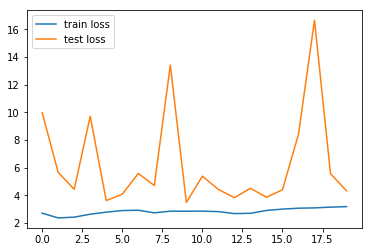

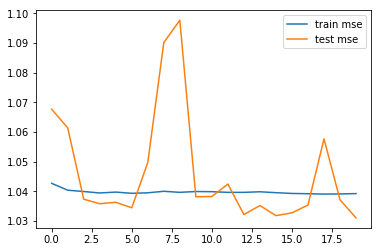

In [14]:
# plot 
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['mean_squared_error'], label="train mse")
plt.plot(r.history['val_mean_squared_error'], label="test mse")
plt.legend()
plt.show()